In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, plot_precision_recall_curve, roc_curve
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, precision_recall_curve, auc, recall_score, precision_score, confusion_matrix
from collections import Counter
from sklearn.decomposition import PCA
import collections


## Defination-1-Values calculating

In [2]:
### Enrichment Factor
def EF(y_prob, y_test, n_percent):
    actives_list = y_test
    score_list = y_prob
    total_actives = len(actives_list[actives_list == 1])
    total_compounds = len(actives_list)
    # Sort scores, while keeping track of active/decoy status
    # NOTE: This will be inefficient for large arrays
    labeled_hits = sorted(zip(score_list, actives_list), reverse=True)
    # Get top n percent of hits
    num_top = int(total_compounds * n_percent)
    top_hits = labeled_hits[0:num_top]    
    num_actives_top = len([value for score, value in top_hits if value == 1])
    # Calculate enrichment factor
    return num_actives_top / (total_actives * n_percent)
#calculate top hit rate
def tophitrate_per(y_prob, y_test, n_percent):
    pos_al = pd.DataFrame({'prob':y_prob,'Label':y_test})
    num_per = int(len(y_test)*n_percent)
    pos_top = pos_al.nlargest(num_per, 'prob')
    num_active = pos_top['Label'].value_counts()[1]
    return num_active/num_per

## Defination-2-Single Model Evaluation

In [3]:
#obtain a table of top hit rate and enrichment factor of single model
def EFTH(y_prob, y_test,thresh_list = [0.05,0.02, 0.01, 0.005], M="SO"):
    SB_EF1 =[]
    for n in thresh_list:
        ef_RFscore = EF(y_prob, y_test, n)
        SB_EF1.append(ef_RFscore) 
        #print("RFScore enrichment factor at {}: {:.3f}".format(n, ef_RFscore))

    SB_TH1 =[]
    for n in thresh_list:
        th_RFscore = tophitrate_per(y_prob, y_test, n) 
        SB_TH1.append(th_RFscore) 
        #print("tophit rate at {}: {:.3f}".format(n, th_RFscore)) 
    df = pd.DataFrame({M+'_TH':SB_TH1,M+'_EF':SB_EF1},index=thresh_list)
    df = df.T
    return df
#calculate AUCPR value
def AUCPR_value(y_prob, y_test):
    # calculate the no skill line as the proportion of the positive class
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    print('AUCPR:',auc_precision_recall)
    return auc_precision_recall

#plot a PR curve
def PR_curve(y_prob, y_test,atitle=''):
    # calculate the no skill line as the proportion of the positive class
    y = y_test
    no_skill = len(y[y==1]) / len(y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # calculate model precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    print('AUCPR:',auc_precision_recall)
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label=f'RF (AUCPR = {round(auc_precision_recall,3)})')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.title(atitle)
    # show the plot
    #plt.savefig(save_path, dpi=200)
    plt.show()

def Model_Assessment(df,M="SO"):
    print("Model assessment of "+M+" Model")
    print("\n1)Confusion Matrix")
    y_test = df["Label"]
    y_pred = df[M+"_pre"]
    y_prob = df[M+"_con"]
    confuMatrix_measures(y_pred,y_test)
    print("\n2)Table of Top Hit Rate and Enrichment Factor")
    display(EFTH(y_prob, y_test,[0.05,0.02,0.01,0.005,0.001], M))
    print("\n3)Precision Recall Curve and AUCPR")
    PR_curve(y_prob, y_test,atitle="Precision Recall Curve of "+M+" Model")

## Defination-1-Multi Model Evaluation(plot)

In [4]:
#Out put a confusion matrix and return evaluation matrix
def confuMatrix_measures(y_pred,y_test):
    print('\nConfusion matrix of Random Forest on the test data:')
    confu_mtrx = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0,1]), 
                              columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])    
    print(confu_mtrx)
    
    TP = confu_mtrx.iloc[1,1]
    TN = confu_mtrx.iloc[0,0]
    FP = confu_mtrx.iloc[0,1]
    FN = confu_mtrx.iloc[1,0]
    
    print("TP:", TP)
    print("TN:", TN)
    print("FP:", FP)
    print("FN:", FN)
    
    Sensitivity = TP/(TP+FN) #pred_+ of all + also called recall
    Specifity = TN/(TN + FP) #pred_- of all -
    Precision = TP/(TP+FP) # + of all pred_+
    Accuracy = (TP+TN)/(TP+TN+FP+FN) # right prediction of all prediction
    FPR = FP/(FP+TN) #False_positive_rate, pred_+ but in fact - of all -
    PPV = TP/(TP+FP) #Positive predictive value, real+ in all +_pred
    NPV = TN/(FN+TN) #Negative predictive value, real- in all -pred
    BER = 1/2*(FPR + FN/(FN+TP)) #balanced positive rate
    record_df = pd.DataFrame(
        {'Sensitivity': [Sensitivity],'Specifity':[Specifity], 
         'Precision':[Precision], 'Accuracy':[Accuracy], "FRP":[FPR], "BER":[BER],
         'PPV':[PPV], 'NPV': [NPV], "TP": [TP], "TN": [TN],"FP": [FP],"FN": [FN]}, 
        columns=['Sensitivity', 'Specifity', 'Precision', 'Accuracy', 
                 'PPV', 'NPV', "TP", "TN","FP","FN"]
        )
    return record_df
    
#prepare a compressed table of enrichment factor group by 18 protein target at different thresh_hold.
def EF_multi_receptor(df,Ms=["MO","MB","SO","SB","Consensus"],thresh_list = [0.05,0.02, 0.01, 0.005]): 
    df_EF = pd.DataFrame()
    #group data by Receptor name
    Recs = df["Receptor"].drop_duplicates().to_list() #create a list of receptor name 
    EF_n_M = pd.DataFrame()
    for n in thresh_list:
        df_rec_M = pd.DataFrame()
        for Rec in Recs:
            df_receptor = df[df["Receptor"]==Rec]
            y_test = df_receptor["Label"]
            EF_scores = [] 
            for M in Ms:               
                y_pred = df_receptor[M+"_pre"]
                y_prob = df_receptor[M+"_con"]                
                EF_score = EF(y_prob, y_test, n)                
                EF_scores.append(EF_score)
            df_rec_M = pd.concat([df_rec_M,pd.DataFrame({Rec:EF_scores},index=Ms)],axis=1)#Rec = colname, index=M
            #display(df_rec_M)
        EF_1_M = df_rec_M.values.tolist()#one new col,index=M
        df_EF = pd.concat([df_EF,pd.DataFrame({n:EF_1_M},index=Ms)],axis=1)
    return df_EF
#prepare a compressed table of average enrichment factor for all sample at different thresh_hold.
def EF_multi_avg(df,Ms=["MO","MB","SO","SB","Consensus"],thresh_list = [0.05,0.02, 0.01, 0.005]):
    y_test = df["Label"]
    df_EF = pd.DataFrame()
    for M in Ms:               
        y_pred = df[M+"_pre"]
        y_prob = df[M+"_con"]
        EF_scores = []        
        for n in thresh_list:
            EF_score = EF(y_prob, y_test, n)
            EF_scores.append(EF_score)       
        df_EF = pd.concat([df_EF,pd.DataFrame({M:EF_scores},index=thresh_list)],axis=1)
    return df_EF.T

#define the color of different box
def set_box_color(bp, color):
    plt.setp(bp[ 'medians'], color="white")
    for item in ['fliers','boxes', 'whiskers','caps']:
        plt.setp(bp[item], color= color)
        
#input: df_EF_mul, df_EF_mul_avg
def plot_EF(df_mul,df_avg,Ms=["MO","MB","SO","SB","Consensus"],thresh_list = [0.05,0.02, 0.01, 0.005]):
    ticks = []
    df_mul["all"] = df_EF_mul.values.tolist()
    for i in thresh_list:
        num = str(i).split(".")[-1][1:]
        tick = "EF" + num
        ticks.append(tick)
    colors = ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e"]
    labels = ["MO","MB","SO","SB","Consensus"]
    wid = 0.6
    gap = 0.2
    dist = wid+gap
    n_model = len(Ms)
    num_str = [str(i) for i in list(range(0,len(Ms)))]
    for i in num_str:
        locals()[i] = list(df_mul.iloc[int(i),-1])#call the "all" column as input
        locals()["avg"+i] = list(df_avg.iloc[int(i),:])
        
        positions = np.array(range(len(locals()[i])))*n_model+dist*int(i)-2*dist 
        plt.scatter(x=positions,y=locals()["avg"+i],s=18.,marker="D",color="black",zorder=1)

        flierprops = dict(marker='o', markeredgecolor=colors[int(i)], markersize=5)
        locals()["bp"+i] = plt.boxplot(locals()[i], flierprops = flierprops,
                                       positions=positions,patch_artist=True, widths=wid,zorder=0)  
        set_box_color(locals()["bp"+i], colors[int(i)])
        plt.plot([], c=colors[int(i)], label=labels[int(i)])

    plt.legend()    
    plt.xticks(range(0, len(ticks) * n_model,n_model), ticks)
    plt.xlim(-n_model, len(ticks)*n_model)
    plt.ylabel("Enrichment Factor")
    plt.rcParams['figure.dpi']=300
    plt.rcParams['figure.figsize']=(8,6)
    plt.show()
    
#plot PR_curve of multiple models    
def PR_curve_multi(df,Ms=["MO","MB","SO","SB","Consensus"],atitle="Precision Recall Curve"):
    y_test = df["Label"]
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y_test[y_test==1]) / len(y_test)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    colors = ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e"]                   
    for M in Ms:               
        y_pred = df[M+"_pre"]
        y_prob = df[M+"_con"]
        # calculate model precision-recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        # Use AUC function to calculate the area under the curve of precision recall curve
        auc_precision_recall = auc(recall, precision)
        # plot the model precision-recall curve
        plt.plot(recall, precision, marker='.',
                 label=f'RF_{M} (AUCPR = {round(auc_precision_recall,3)})')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.title(atitle)
    # show the plot
    #plt.savefig("AUCPR.png", dpi=200)
    plt.rcParams['figure.dpi']=300
    plt.rcParams['figure.figsize']=(8,6)
    plt.show()  

## Read in data

In [5]:
# read in prediction result(predicted label; probability) of the different model, with receptor, compound name, preknown label.
df_sum = pd.read_csv("MLSF_results_DEKOIS2.csv")
df_sum

,Compound,Label,SB_con,SB_pre,MB_con,MB_pre,SO_con,SO_pre,MO_con,MO_pre,Consensus_con,Consensus_pre,Receptor
0,BDB10516,1,0.361109,0,0.398375,0,0.042706,0,0.060005,0,0.215549,0,ACHE_protein_receptor.pdbqt
1,BDB12915,1,0.352626,0,0.414035,0,0.142281,0,0.125114,0,0.258514,0,PI3Kg_protein_receptor.pdbqt
2,BDB13246,1,0.364039,0,0.272496,0,0.106912,0,0.025709,0,0.192289,0,JAK3_protein_receptor.pdbqt
3,BDB13268,1,0.430645,0,0.260514,0,0.059228,0,0.043723,0,0.198527,0,JAK3_protein_receptor.pdbqt
4,BDB13344,1,0.669527,1,0.370305,0,0.048483,0,0.100018,0,0.297083,0,P38-alpha_protein_receptor.pdbqt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21929,ZINC32096082,0,0.525206,1,0.233593,0,0.098600,0,0.088295,0,0.236424,0,PI3Kg_protein_receptor.pdbqt
21930,ZINC32096108,0,0.364891,0,0.324470,0,0.057074,0,0.101381,0,0.211954,0,PNP_protein_receptor.pdbqt
21931,ZINC32096526,0,0.821536,1,0.459813,0,0.379401,0,0.173628,0,0.458595,0,PNP_protein_receptor.pdbqt
21932,ZINC32096801,0,0.724168,1,0.554724,1,0.124823,0,0.153835,0,0.389388,0,HSP90_protein_receptor.pdbqt


## Evaluation-1-Single Model

Model assessment of Consensus Model

1)Confusion Matrix

Confusion matrix of Random Forest on the test data:
     pred_neg  pred_pos
neg     21048       169
pos       616       101
TP: 101
TN: 21048
FP: 169
FN: 616

2)Table of Top Hit Rate and Enrichment Factor


,0.050,0.020,0.010,0.005,0.001
Consensus_TH,0.168796,0.283105,0.433790,0.633028,0.904762
Consensus_EF,5.160391,8.647141,13.249651,19.246862,26.499303



3)Precision Recall Curve and AUCPR
AUCPR: 0.1828849271477614


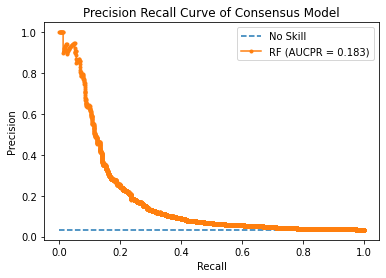

In [6]:
#Model_Assessment(df_sum,"SO")
#Model_Assessment(df_sum,"MO")
#Model_Assessment(df_sum,"SB")
#Model_Assessment(df_sum,"MB")
Model_Assessment(df_sum,"Consensus")

In [8]:
#build an average EF table
df_EF_mul_avg = EF_multi_avg(df=df_sum)
display(df_EF_mul_avg)
df_EF_mul = EF_multi_receptor(df=df_sum)
display(df_EF_mul)


,0.050,0.020,0.010,0.005
MO,4.741980,8.368201,12.412831,17.573222
MB,3.737796,6.276151,10.878661,16.736402
SO,4.741980,6.834031,8.228731,8.368201
SB,2.510460,3.138075,4.602510,5.857741
Consensus,5.160391,8.647141,13.249651,19.246862


,0.050,0.020,0.010,0.005
MO,"[0.0, 2.0, 5.128205128205128, 3.5, 3.589743589...","[0.0, 2.5, 8.974358974358974, 6.25, 6.41025641...","[0.0, 2.5, 15.384615384615383, 10.0, 12.820512...","[0.0, 5.0, 25.64102564102564, 15.0, 20.5128205..."
MB,"[8.0, 2.0, 4.102564102564102, 3.0, 4.102564102...","[12.5, 3.75, 7.692307692307692, 6.25, 6.410256...","[15.0, 5.0, 12.82051282051282, 10.0, 12.820512...","[20.0, 5.0, 15.384615384615383, 10.0, 10.25641..."
SO,"[7.5, 1.0, 7.179487179487179, 4.0, 3.589743589...","[8.75, 2.5, 10.256410256410255, 5.0, 7.6923076...","[15.0, 2.5, 10.256410256410255, 7.5, 12.820512...","[10.0, 0.0, 15.384615384615383, 10.0, 15.38461..."
SB,"[0.5, 2.5, 1.0256410256410255, 1.5, 3.58974358...","[0.0, 2.5, 0.0, 2.5, 5.128205128205128, 5.0, 8...","[0.0, 5.0, 0.0, 2.5, 5.128205128205128, 2.5, 1...","[0.0, 5.0, 0.0, 5.0, 5.128205128205128, 0.0, 1..."
Consensus,"[6.5, 1.0, 5.6410256410256405, 3.0, 3.07692307...","[7.5, 2.5, 8.974358974358974, 3.75, 7.69230769...","[12.5, 5.0, 15.384615384615383, 7.5, 12.820512...","[15.0, 10.0, 20.51282051282051, 15.0, 25.64102..."


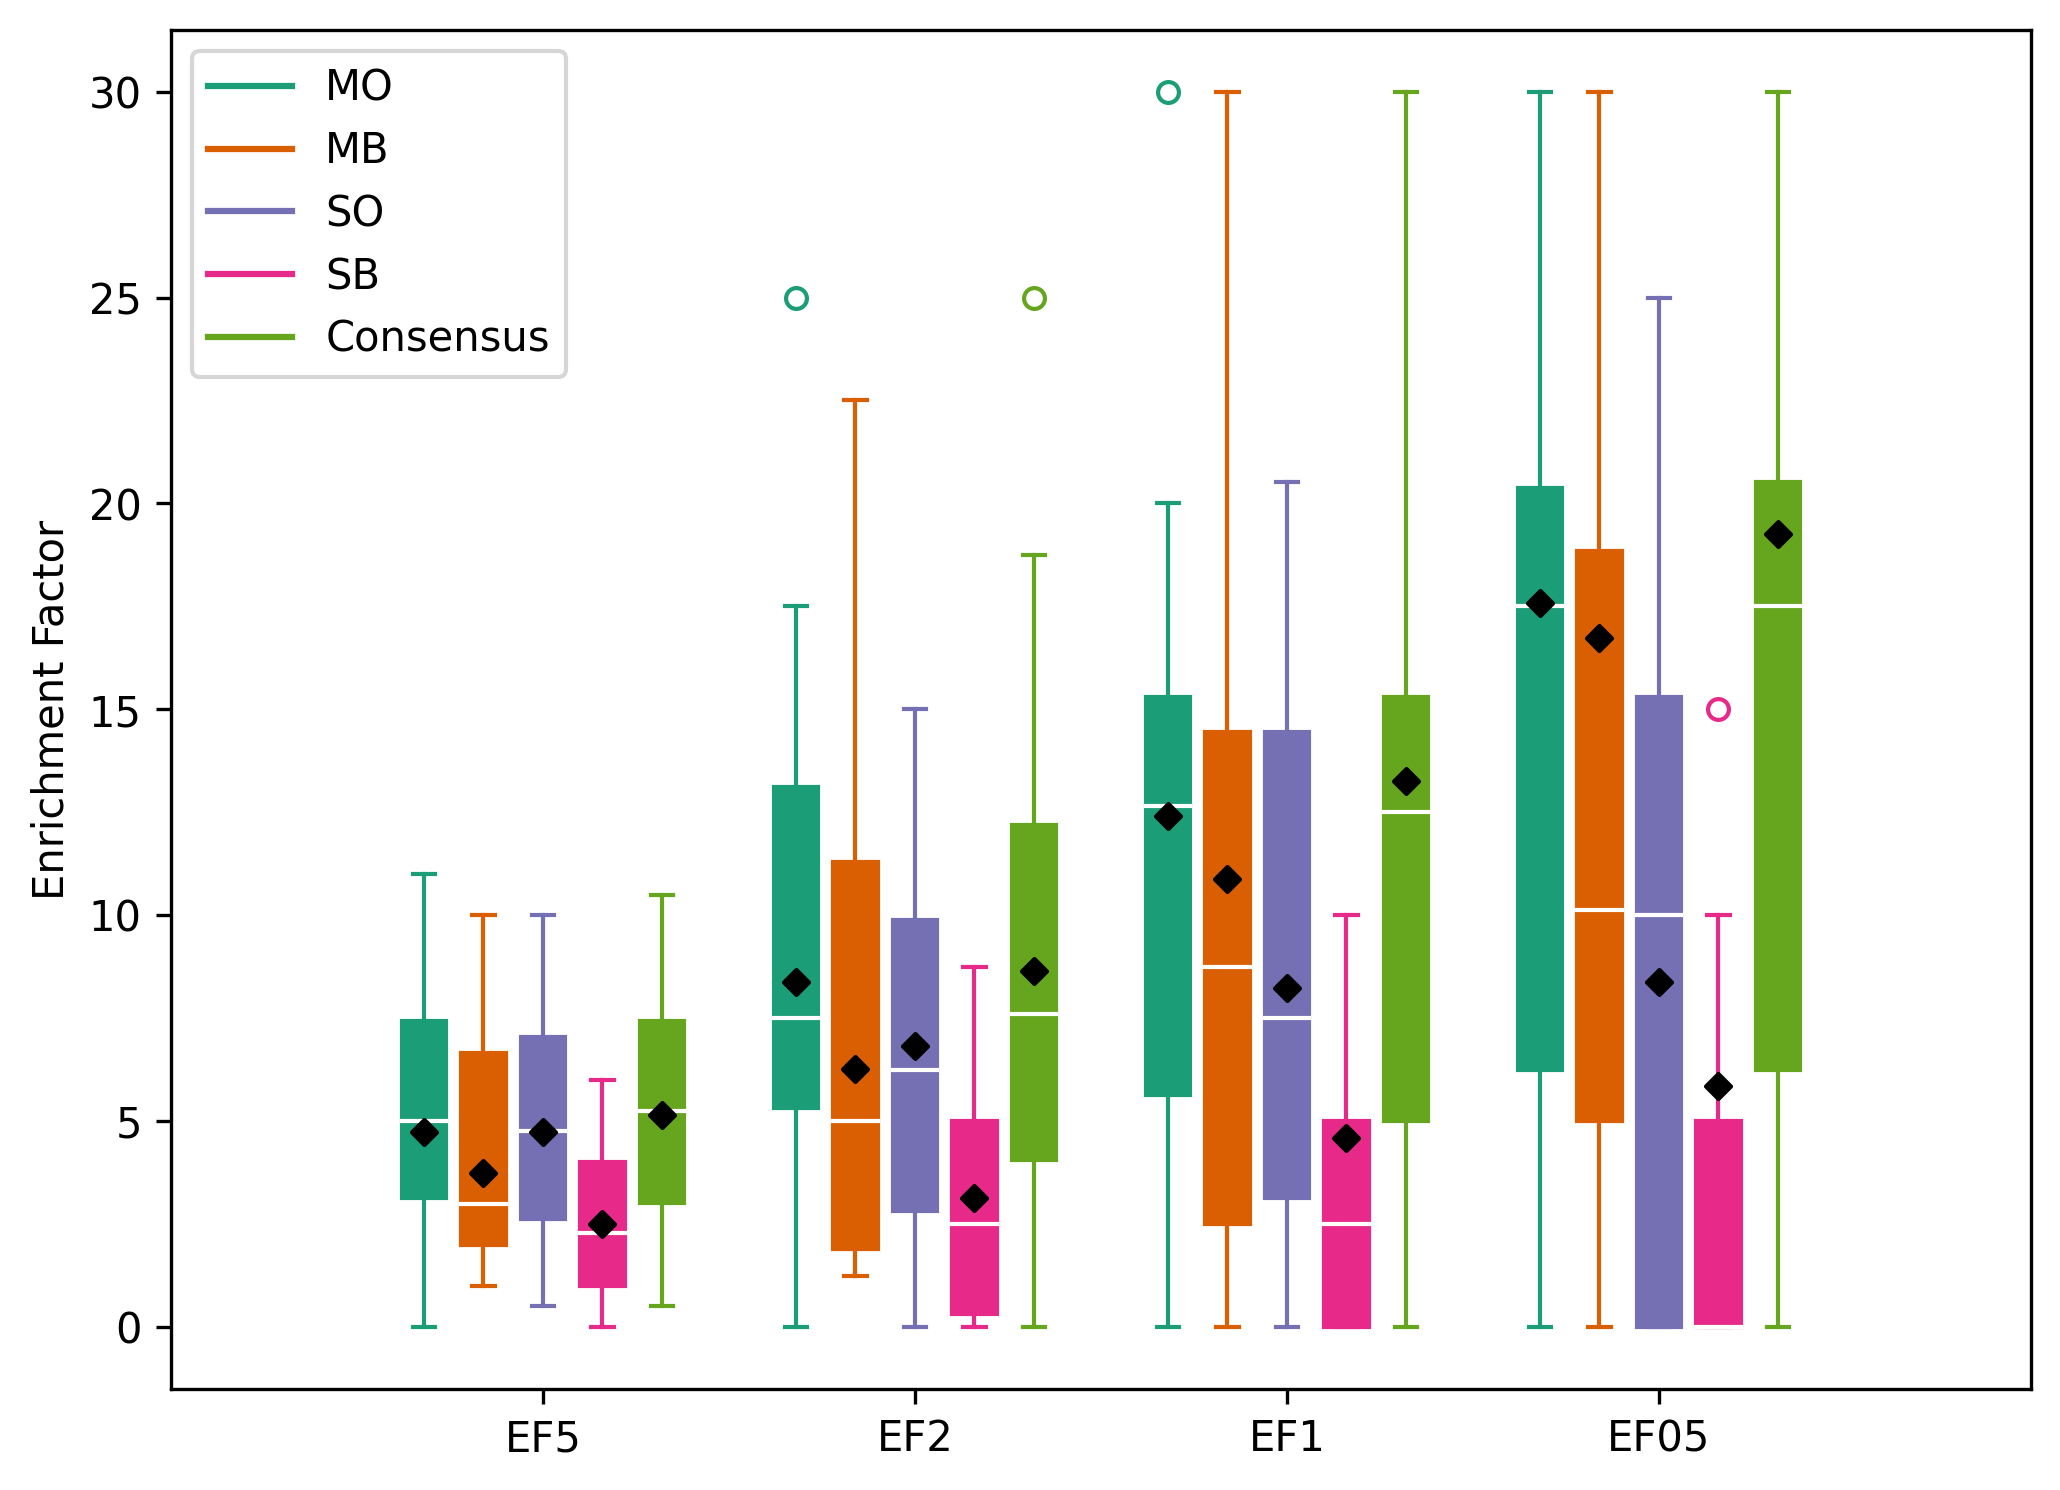

In [9]:
#Plot EF
plot_EF(df_EF_mul,df_EF_mul_avg)


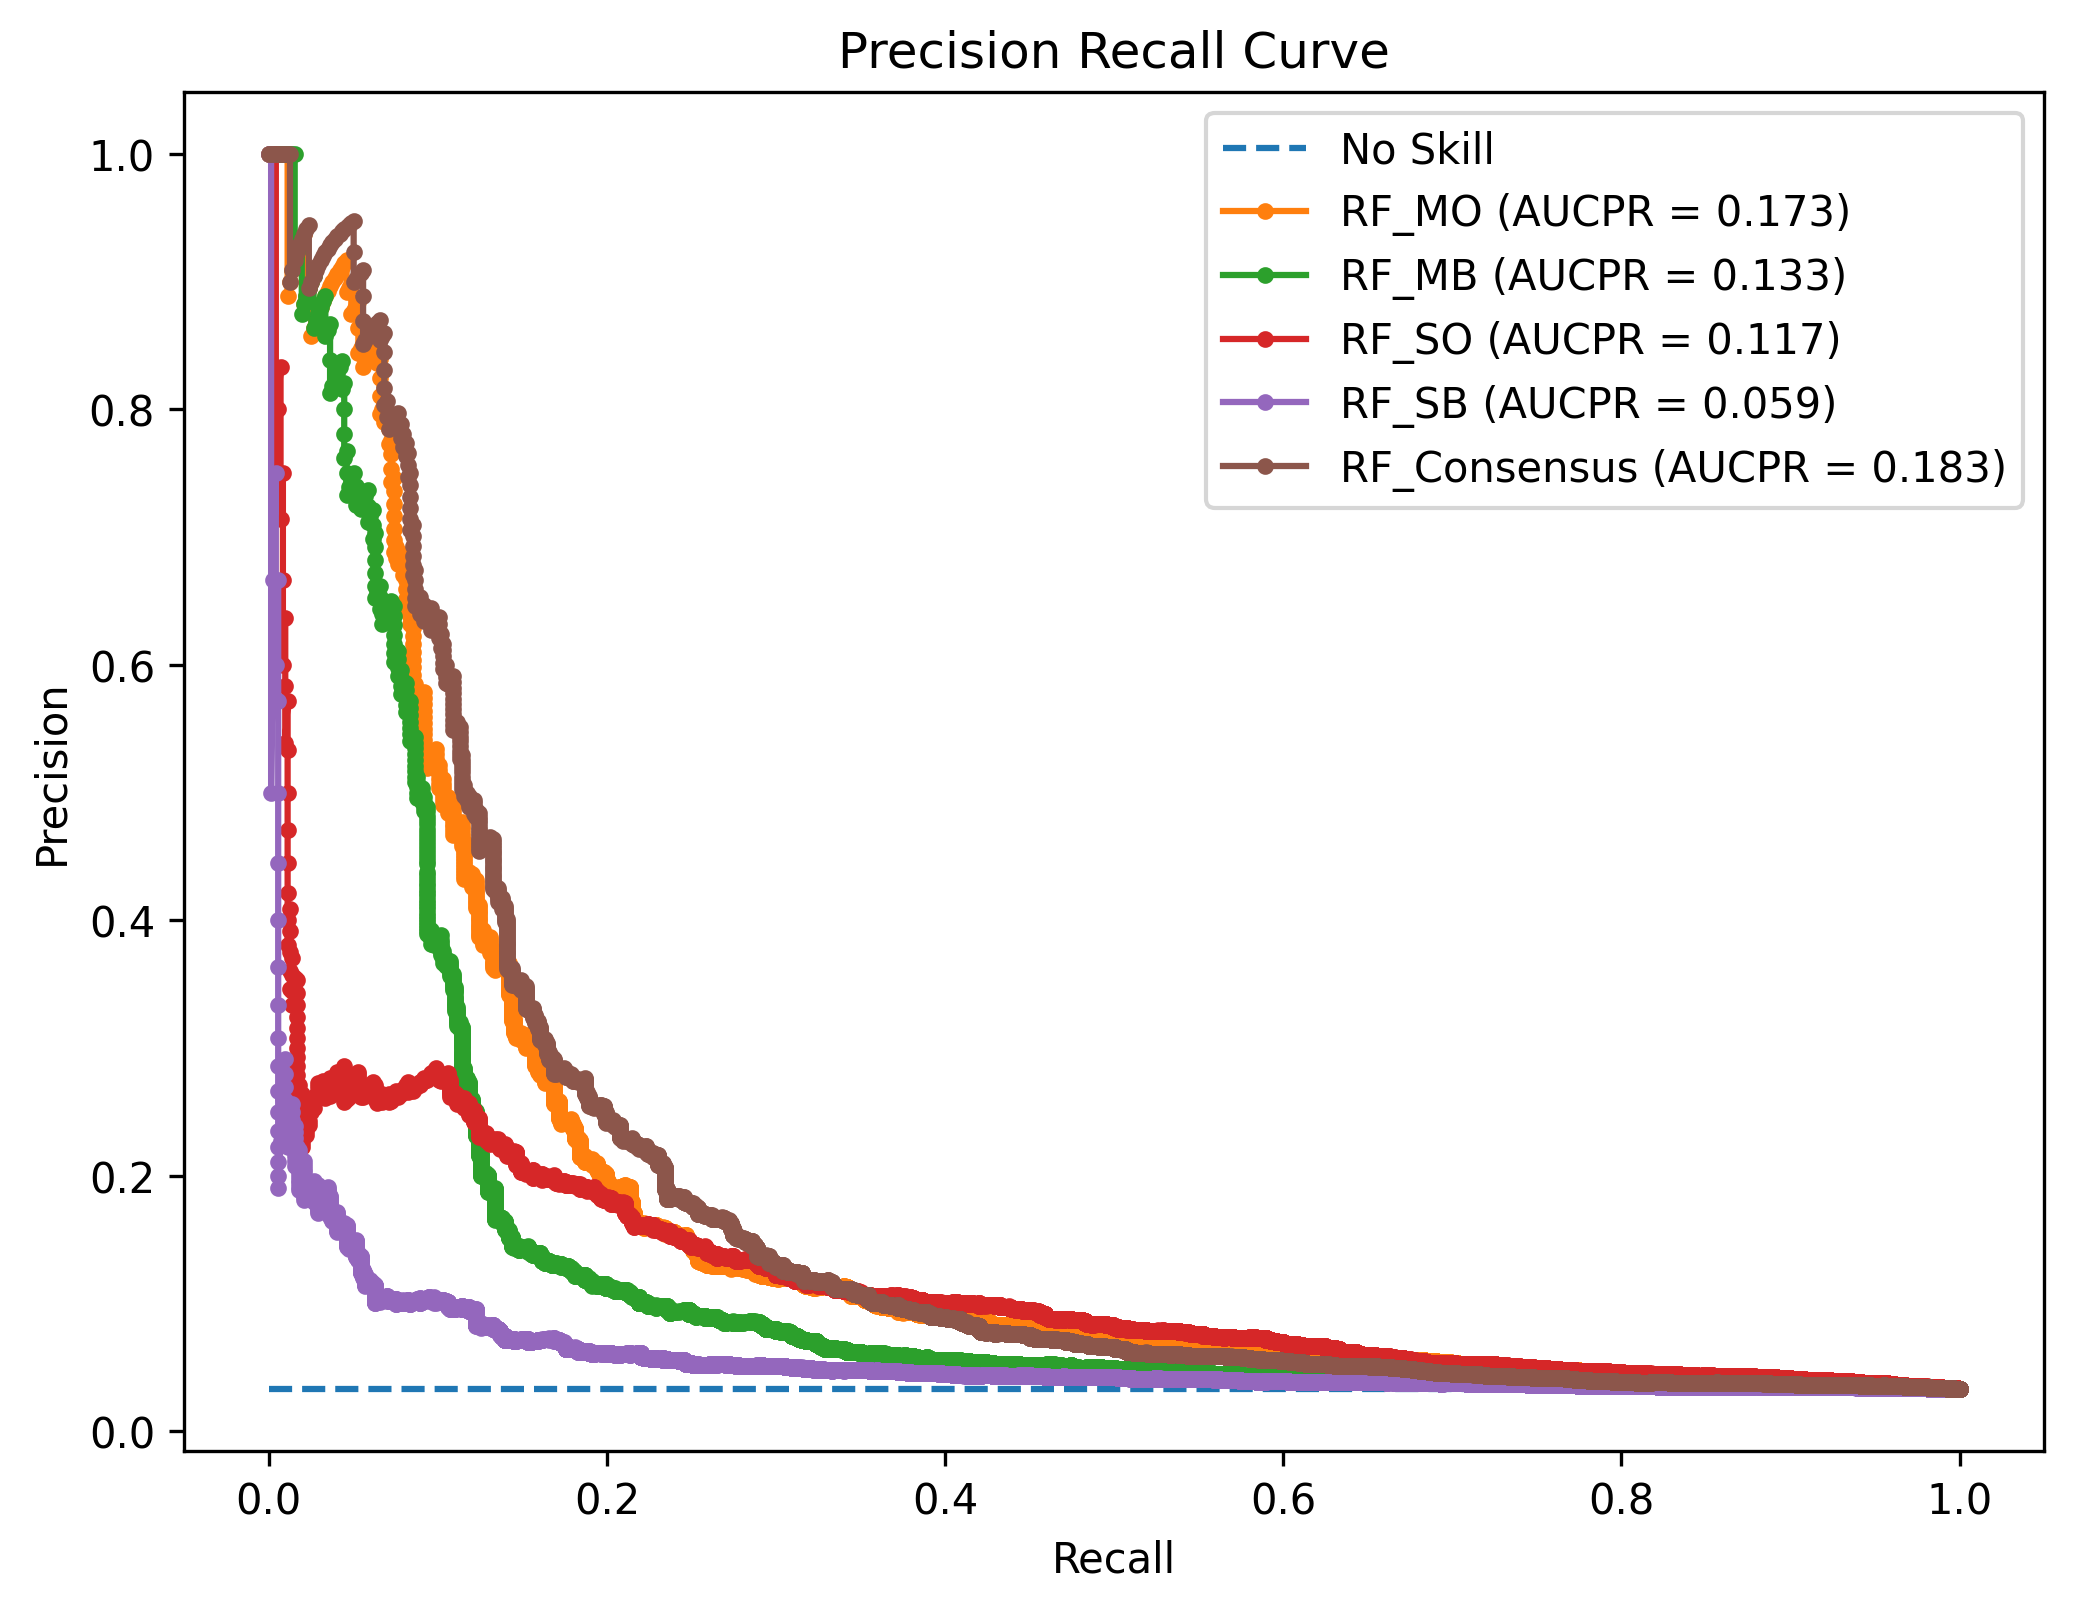

In [10]:
#Plot PR curve
PR_curve_multi(df_sum)